# ハッシュタグのカテゴリ分類の性能比較

In [1]:
import pandas as pd
df = pd.read_csv('input/hashtags.csv')
df_category = pd.DataFrame(df['category'].unique(), columns=['category'])
print(df.groupby('category').count())

              hashtag
category             
アート・デザイン           45
クッキング・レシピ          55
サイエンス・科学           39
スポーツ               49
テクノロジー・ガジェット       50
ビジネス・経済            43
ファッション・ビューティ       43
ブック・文学             38
ライフスタイル・生活         38
健康・ウェルネス           44
政治・社会問題            53
教育・学習              41
旅行・アウトドア           51
映画・ドラマ             51
音楽                 55


## ハッシュタグをベクトルに変換する

In [2]:
import torch
from abc import ABC, abstractmethod
from sklearn.metrics.pairwise import cosine_similarity
from transformers import BertModel, BertTokenizer

class EmbeddingModel(ABC):
    @abstractmethod
    def convert_to_vector(self, text):
        pass

class BERTModel(EmbeddingModel):
    def __init__(self, model_name="bert-base-uncased"):
        self.tokenizer = BertTokenizer.from_pretrained(model_name)
        self.model = BertModel.from_pretrained(model_name)
        
    def convert_to_vector(self, text):
        inputs = self.tokenizer(text, return_tensors="pt")
        with torch.no_grad():
            outputs = self.model(**inputs)
        vector = outputs.last_hidden_state[0, 0, :].numpy().tolist()
        return vector


In [27]:
import time

def add_vector_column(df: pd.DataFrame, model: EmbeddingModel, column: str) -> pd.DataFrame:
    start_time = time.time()

    # 文字列をベクトルに変換して新しい列に追加
    df.loc[:, column+'_vector'] = df[column].apply(model.convert_to_vector)

    # 処理時間の計測終了と結果の出力
    elapsed_time = time.time() - start_time
    print(f"Elapsed time: {elapsed_time} seconds")

    return df

## ベクトルから最も類似するカテゴリを計算する

In [4]:
import numpy as np

def predict_category(df_hashtag: pd.DataFrame, df_category: pd.DataFrame) -> pd.DataFrame:
    # ベクトルのリストを取得し、NumPy配列に変換
    hashtag_vectors = np.array(df_hashtag['hashtag_vector'].tolist())
    category_vectors = np.array(df_category['category_vector'].tolist())

    # 各ハッシュタグベクトルと全カテゴリベクトルのコサイン類似度を計算
    cosine_similarities = cosine_similarity(hashtag_vectors, category_vectors)

    # 最も類似度が高いカテゴリのインデックスを取得
    predicted_category_indices = np.argmax(cosine_similarities, axis=1)

    # 最大類似度を取得
    max_similarities = np.max(cosine_similarities, axis=1)

    # 予測カテゴリを取得
    predicted_categories = df_category['category'].iloc[predicted_category_indices].values

    # df_hashtagに新しい列を追加
    df_hashtag['predict_category'] = predicted_categories
    df_hashtag['cosine_similarity'] = max_similarities

    return df_hashtag

## カテゴリ分類結果の評価

各評価指標

- **Accuracy（精度）**: Accuracyはモデルがクラスを正しく予測した割合です。すべての真正（真のクラスが正で予測も正）と真陰性（真のクラスが負で予測も負）の数を、全てのケースの数で割ったものになります。ただし、各クラスのサンプル数がバランスしていない場合（不均衡データ）には、この指標は誤解を招く可能性があります。

- **Precision（適合率）**: Precisionは、モデルが正と予測したサンプルのうち、実際に正であったサンプルの割合を示します。偽陽性（実際は負だが、予測は正）を避けることが重要な場合（例えば、スパムメールのフィルタリング）に特に役立つ指標です。

- **Recall（再現率）**: Recallは、実際の正のサンプルのうち、モデルが正と予測したサンプルの割合を示します。偽陰性（実際は正だが、予測は負）を避けることが重要な場合（例えば、病気の診断）に特に役立つ指標です。

- **F1 Score（F1スコア）**: F1 ScoreはPrecisionとRecallの調和平均をとったもので、これら2つの評価指標のバランスを示します。F1スコアは、PrecisionとRecallの両方が重要な場合に特に有用です。F1スコアは1に近いほど良い性能を示し、0に近いほど低い性能を示します。

混同行列のヒートマップ

- **数字**: 数字は各セルの具体的な値を示しています。つまり、特定の「実際のクラス」（行）と「予測されたクラス」（列）の組み合わせがデータセット内で何回発生したかを示しています。
- **色の濃さ**: 色の濃さはそのセルの値が相対的にどの程度大きいかを視覚的に表現しています。色が濃いほど、そのセルの値が大きい（つまり、その「実際のクラス」vs「予測されたクラス」の組み合わせが多く発生した）ことを意味します。これにより、一見してモデルがどのクラスをどの程度正しく予測できたか、またどのクラスで最も間違いが多かったかなど、全体のパターンを把握することが容易になります。

In [5]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

def evaluation(df_predicted: pd.DataFrame):
    # 予測と実際のカテゴリを取得
    y_true = df_predicted['category']
    y_pred = df_predicted['predict_category']

    # 評価指標の計算
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(f'Accuracy: {accuracy:.2f}\nPrecision: {precision:.2f}\nRecall: {recall:.2f}\nF1 Score: {f1:.2f}')

    # 混同行列の作成
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt="d", cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

### BERTを使ったカテゴリ分類

In [36]:
# # 1回目のみ
# bert_model = BERTModel()

# # ハッシュタグをベクトル変換してcsv出力
# df_bert = add_vector_column(df, bert_model, 'hashtag')
# df_bert.to_csv('output/hashtags_bert.csv', index=False)

# # カテゴリをベクトル変換してcsv出力
# df_category_bert = add_vector_column(df_category, bert_model, 'category')
# df_category_bert.to_csv('output/categories_bert.csv', index=False)

print('Elapsed time: 32.517783641815186 seconds')
print('Elapsed time: 0.8807814121246338 seconds')

Elapsed time: 32.517783641815186 seconds
Elapsed time: 0.8807814121246338 seconds


In [ ]:
# 2回目以降
df_bert = pd.read_csv('output/hashtags_bert.csv')
df_category_bert = pd.read_csv('output/categories_bert.csv')

In [7]:
# # 1回目のみ
# df_bert_predicted = predict_category(df_bert, df_category_bert)
# df_bert_predicted.to_csv('output/hashtags_bert_predicted.csv', index=False)

# 2回目以降
df_bert_predicted = pd.read_csv('output/hashtags_bert_predicted.csv')

df_bert_predicted.head()

,hashtag,category,hashtag_vector,predict_category,cosine_similarity
0,サッカー,スポーツ,"[-0.4107682406902313, -0.5052114129066467, -0....",アート・デザイン,0.952842
1,野球,スポーツ,"[-0.2615754306316376, 0.09152048081159592, -0....",健康・ウェルネス,0.953856
2,ラグビー,スポーツ,"[-0.31610018014907837, -0.8343167304992676, -0...",クッキング・レシピ,0.945390
3,マラソン,スポーツ,"[-0.5356400012969971, 0.5024380683898926, -0.5...",音楽,0.984449
4,バレーボール,スポーツ,"[-0.5938227772712708, -0.46884140372276306, -0...",アート・デザイン,0.968736


Accuracy: 0.12
Precision: 0.15
Recall: 0.12
F1 Score: 0.12


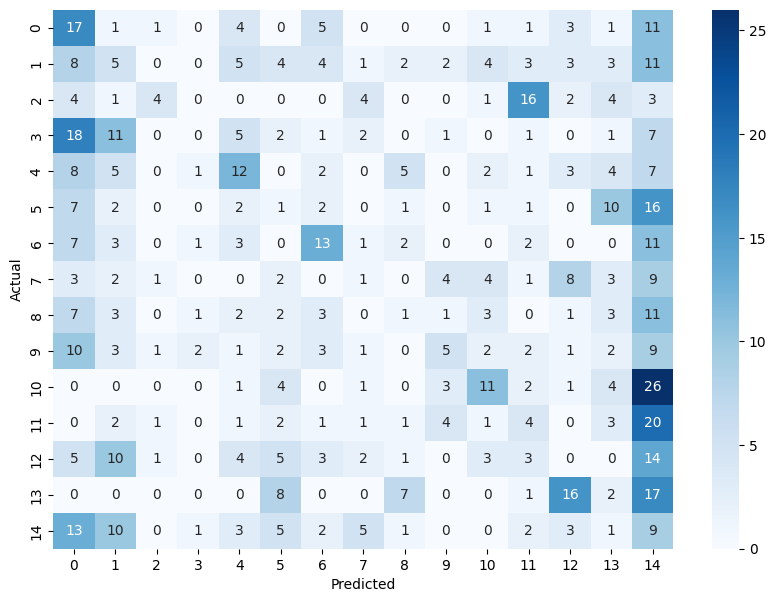

In [8]:
evaluation(df_bert_predicted)

### OpenAI Embedding APIを使ったカテゴリ分類

In [25]:
import os
import csv
import openai
from openai.embeddings_utils import get_embedding

In [30]:
class OpenAIModel(EmbeddingModel):
    def __init__(self):
        openai.api_key = os.getenv("OPENAI_API_KEY")
        self.openai = openai
        
    def convert_to_vector(self, text):
        response = self.openai.Embedding.create(
          model="text-embedding-ada-002",
          input=text
        )
        
        # 消費したトークン数をCSVに記録
        filename = 'output/openai_usage_tokens.csv'
        file_exists = os.path.isfile(filename)
        
        with open(filename, mode='a') as file:
            writer = csv.writer(file)
            if not file_exists:
                writer.writerow(['Text', 'Total Tokens'])
            writer.writerow([text, response['usage']['total_tokens']])
        
        # vectorを返却
        return response['data'][0]['embedding']

https://openai.com/pricing
| Model     | Usage               |
|-----------|---------------------|
| Ada v2    | `$0.0001 / 1K tokens` |
| Ada v1    | `$0.0040 / 1K tokens` |
| Babbage v1| `$0.0050 / 1K tokens` |
| Curie v1  | `$0.0200 / 1K tokens` |
| Davinci v1| `$0.2000 / 1K tokens` |


In [43]:
# # 1回目のみ
# openai_model = OpenAIModel()

# # ハッシュタグをベクトル変換してcsv出力
# df_openai = add_vector_column(df, openai_model, 'hashtag')
# df_openai.to_csv('output/hashtags_openai.csv', index=False)

# # カテゴリをベクトル変換してcsv出力
# df_category_openai = add_vector_column(df_category, openai_model, 'category')
# df_category_openai.to_csv('output/categories_openai.csv', index=False)

print('Elapsed time: 253.96260690689087 seconds')
print('Elapsed time: 4.664952278137207 seconds')

df_openai_usage_tokens = pd.read_csv('output/openai_usage_tokens.csv')
total_tokens = df_openai_usage_tokens["Total Tokens"].sum()
print(f"Total tokens: {total_tokens}, ${(total_tokens/1000)*0.0001}")

Elapsed time: 253.96260690689087 seconds
Elapsed time: 4.664952278137207 seconds
Total tokens: 3830, $0.00038300000000000004


In [37]:
# 2回目以降
df_openai = pd.read_csv('output/hashtags_openai.csv')
df_category_openai = pd.read_csv('output/categories_openai.csv')

In [ ]:
# import ast

# # `hashtag_vector`列の値をリストに変換
# df_openai['hashtag_vector'] = df_openai['hashtag_vector'].apply(ast.literal_eval)

# # リスト内の値を浮動小数に変換
# df_openai['hashtag_vector'] = df_ope

In [49]:
# 1回目のみ
df_openai_predicted = predict_category(df_openai, df_category_openai)
df_openai_predicted.to_csv('output/hashtags_openai_predicted.csv', index=False)

ValueError: could not convert string to float: '[-0.016242749989032745, 0.004789861384779215, 0.0020967796444892883, -0.00990379974246025, -0.02540765330195427, 0.01844647526741028, -0.007097290828824043, -0.023216892033815384, 0.010694548487663269, -0.03235587105154991, 0.017279796302318573, 0.003525960026308894, 0.008063040673732758, 0.0022247901652008295, -0.004653748590499163, -0.005664869677275419, 0.0285187941044569, -0.01963907852768898, 0.01425939705222845, -0.03997816517949104, 0.005100975278764963, -0.002247475553303957, -0.009838984347879887, -0.030852150171995163, -0.028259532526135445, 0.0019379816949367523, 0.005010233726352453, -0.02719656005501747, 0.0029912327881902456, -0.016864977777004242, 0.038759633898735046, -0.03704850748181343, -0.01416865549981594, -0.027637304738163948, -0.020131677389144897, -0.03111141361296177, -0.004721804987639189, -0.0006773213972337544, 0.00026007197448052466, -0.008348229341208935, 0.02558913640677929, 0.017500169575214386, 0.005541720427572727, -0.014233470894396305, -0.015270518139004707, 0.010610288009047508, -0.011627890169620514, 0.00037511938717216253, -0.0005306764505803585, 0.0073565528728067875, 0.003632905660197139, 0.017798321321606636, -0.025783583521842957, -0.0318114198744297, 0.006727843079715967, -0.02059834823012352, 0.0021696968469768763, 0.004157910589128733, 0.00012112385593354702, -0.02577061951160431, 0.002357661724090576, 0.012243636883795261, -0.03406699746847153, 0.01987241394817829, -0.01578904129564762, 0.007226922083646059, -0.029892882332205772, -0.014894588850438595, -0.044178206473588943, -0.0008644759654998779, 0.015516816638410091, 0.016502011567354202, 0.007907483726739883, -0.019250186160206795, 0.019146481528878212, -0.009404720738530159, -0.005434774793684483, -0.005894964560866356, 0.003367162309587002, -0.009540833532810211, 0.026029881089925766, -0.018277954310178757, -0.0020805757958441973, -0.028803983703255653, 0.004647267051041126, 0.008581564761698246, -0.006980623118579388, 0.03160401061177254, 0.00049016677075997, 0.0037625364493578672, 0.02281503565609455, 0.013598280027508736, -0.0058884830214083195, 0.010584361851215363, -0.0342484787106514, -0.017007572576403618, -0.01626867614686489, 0.028492867946624756, -0.0024743294343352318, -0.01796684041619301, -0.0032683187164366245, 0.02805212326347828, -0.03707443177700043, -0.0035616084933280945, -0.038292963057756424, 0.00701303081586957, 0.004942177329212427, -0.0014948061434552073, 0.0070389569737017155, -0.020740941166877747, -0.028363237157464027, -0.004806065000593662, 0.006812103092670441, -0.055637575685977936, -0.0249150563031435, 0.004400968551635742, 0.01796684041619301, -0.02653544209897518, -0.014570511877536774, -0.01639830693602562, 0.009735279716551304, 0.003448181552812457, 0.022802073508501053, 0.0051528275944292545, 0.01722794398665428, -0.0037852218374609947, -0.03217438608407974, 0.014194581657648087, 0.0222187340259552, -0.0025796545669436455, 0.05055604502558708, -0.009197311475872993, -0.008043596521019936, 0.018031656742095947, -0.009151940234005451, -0.0007048679399304092, -0.009048235602676868, -0.001419458189047873, -0.03531145304441452, -0.0228279996663332, 0.009586203843355179, 0.013948283158242702, -0.017863135784864426, -0.009754723869264126, -0.0020805757958441973, -0.00586903840303421, 0.02150576375424862, -0.01473903190344572, 0.0017095073126256466, 0.0005671351100318134, 0.021907620131969452, -0.018148323521018028, 0.02906324528157711, 0.011705668643116951, 0.0004986738204024732, 0.014492733404040337, 0.011640853248536587, 0.03297809883952141, 0.0019671486224979162, -0.017746469005942345, 0.01519273966550827, 0.0022717812098562717, 0.007090809289366007, -0.011264923959970474, -0.017435355111956596, 0.03953741863369942, 0.00642645126208663, 0.018653884530067444, 0.0059306132607162, -0.016709420830011368, -0.002743313554674387, 0.02864842675626278, -0.03689295053482056, 0.008698232471942902, -0.01598348841071129, 0.028726205229759216, -0.0207150150090456, 0.03640035167336464, -0.022205770015716553, -0.02072797901928425, -0.020637236535549164, -0.006760250777006149, 0.03098178096115589, 0.012470491230487823, 0.017137203365564346, 0.017370538786053658, 0.02089649811387062, 0.011251960881054401, 0.019963156431913376, -0.025057651102542877, 0.01528348121792078, 0.02859657257795334, 0.0032715594861656427, 0.008458415046334267, -0.6346728205680847, -0.03069659322500229, -0.00198173220269382, -0.006241727154701948, 0.034792929887771606, 0.004844954237341881, 0.02167428471148014, 0.021816877648234367, -0.011686224490404129, -0.02719656005501747, 0.00017834374739322811, 0.014661253429949284, -0.01558163296431303, 0.013066793791949749, 0.0028956299647688866, -0.012969570234417915, 0.016346454620361328, -0.01402606163173914, -0.0037074433639645576, 0.006095892284065485, -0.007816742174327374, 0.0030058161355555058, -0.008523230440914631, -0.003639387199655175, 0.024837277829647064, 0.020559458062052727, -0.015413112007081509, -0.017396464943885803, -0.02168724685907364, 0.011226034723222256, -0.015335333533585072, 0.010979736223816872, 0.00019029408576898277, -0.014311250299215317, 0.059059832245111465, 0.01416865549981594, -0.017863135784864426, 0.04184484854340553, 0.004319949075579643, 0.04757453501224518, -0.006079688668251038, -0.008328784257173538, 0.003863000310957432, -0.010856586508452892, 0.006345431786030531, 0.014246433973312378, 0.008121374994516373, -0.011310295201838017, 0.01790202595293522, -0.012956607155501842, -0.012295489199459553, -0.014726068824529648, 0.0011277886806055903, 0.013287166133522987, 0.009813058190047741, 0.0240206029266119, 0.006082929205149412, -0.0002647305664140731, -0.0025051168631762266, -0.0030366035643965006, -0.01616497151553631, 0.021570580080151558, -0.012509380467236042, -0.03188919648528099, -0.001993074780330062, 0.010992699302732944, -0.027429895475506783, 0.0006011632503941655, 0.008938049897551537, 0.008063040673732758, -0.004585692659020424, 0.020209455862641335, 0.014726068824529648, -0.0024435422383248806, 0.0174094270914793, 0.011012143455445766, 0.039667051285505295, -0.022620590403676033, -0.012425119988620281, -0.004929214250296354, -0.007265811320394278, -0.007181551307439804, -0.014013098552823067, -0.008840826340019703, 0.011789929121732712, -0.028311384841799736, -0.05423756316304207, 0.005165790673345327, 0.01111584808677435, 0.005062086042016745, 0.01651497557759285, 0.03315958008170128, -0.0025504876393824816, 0.006594971287995577, -0.017396464943885803, 0.015594596043229103, -0.00910008791834116, 0.0014794125454500318, 0.004994030110538006, -0.011718631722033024, -0.01783720962703228, 0.00972879771143198, -0.010214913636446, -0.0009519768063910306, -0.0009187589166685939, 0.006565804593265057, -0.019263150170445442, 0.023022444918751717, 0.026016918942332268, -0.02347615361213684, 0.015348296612501144, -0.005337551701813936, 0.0021113629918545485, -0.01735757477581501, 0.021933546289801598, -0.03471514955163002, 0.01228252612054348, -0.007168588228523731, 0.023994676768779755, -0.018640920519828796, 0.03577812388539314, 0.01402606163173914, 0.03199290111660957, 0.006876918487250805, -0.02486320398747921, 0.02792249247431755, -0.021713173016905785, -0.02006686106324196, 0.013403833843767643, -0.026626184582710266, 0.0030366035643965006, 0.008782492950558662, 0.021090945228934288, -0.01825202815234661, 0.01285290252417326, 0.010545472614467144, 0.014531622640788555, -0.0049843075685203075, 0.030489183962345123, -0.011764002963900566, -0.018394622951745987, -0.010739918798208237, -0.005865797400474548, 0.009210274554789066, 0.0019558060448616743, -0.0372299887239933, -0.00882786326110363, 0.013624206185340881, -0.01818721368908882, 0.009702871553599834, -0.005593572743237019, -0.00461161881685257, -0.0005513363867066801, 0.02210206538438797, 0.013948283158242702, -0.011990857310593128, -0.02841508947312832, -0.005476905032992363, -0.03632257506251335, -0.014570511877536774, -0.005891723558306694, -0.0005391834420152009, 0.0004528979188762605, 0.0035162377171218395, -0.010078801773488522, -0.02383911982178688, -0.026224328204989433, 0.002370624803006649, -0.01836869679391384, -0.02545950561761856, 0.007978781126439571, 0.006792658474296331, -0.014726068824529648, 0.021609468385577202, -0.010052875615656376, 0.0020352050196379423, -0.021466875448822975, -0.008225079625844955, 0.005169031675904989, -0.010188987478613853, 0.005156068596988916, -0.036115165799856186, -0.015205702744424343, 0.0028340553399175406, -0.0017646003980189562, 0.02846694178879261, 0.007142661605030298, 0.04119669646024704, 0.006044039968401194, -0.005839871242642403, -0.029452137649059296, 0.008179709315299988, -0.014842736534774303, -0.006316265091300011, 0.02096131443977356, -0.0021437706891447306, -0.00346114463172853, 0.009242681786417961, 0.004971344489604235, 0.0031062799971550703, 0.03689295053482056, -0.00514958705753088, 0.009962134063243866, -0.012626048177480698, 0.0291150975972414, -0.018718700855970383, -0.000768468074966222, -0.006928770802915096, 0.03157808259129524, -0.010461212135851383, -0.009566759690642357, -0.008121374994516373, -0.016009414568543434, -0.009242681786417961, 0.00026756623992696404, 0.01663164235651493, -0.019483521580696106, -0.001997936051338911, 0.00967046432197094, 0.007687111385166645, 0.028752131387591362, -0.03253735229372978, 0.012833457440137863, -0.028389163315296173, 0.015153850428760052, 0.026392849162220955, 0.003927815705537796, 0.013805689290165901, 0.0038467964623123407, -0.0020789552945643663, -0.009119533002376556, 9.043779573403299e-05, -0.019950194284319878, 0.00976120587438345, -0.008510267361998558, -0.03292624652385712, 0.013831615447998047, -0.033185508102178574, 0.05320051684975624, 0.03295217081904411, 0.018226101994514465, 0.0019460837356746197, 0.012237155809998512, -0.011219553649425507, 0.018057582899928093, -0.008367673493921757, 0.036659613251686096, 0.0013303370214998722, -0.0022361327428370714, -0.01831684447824955, -0.02557617425918579, -0.0019882137421518564, -0.010454731062054634, 0.00963805615901947, 0.005943576339632273, -0.03634849935770035, 0.0024403014685958624, -0.0036782764364033937, -0.007764889858663082, 0.019263150170445442, 0.014933478087186813, 0.026328032836318016, 0.021181687712669373, 0.014583474956452847, 0.012567714788019657, -0.00847137812525034, 0.010487138293683529, -0.01598348841071129, -0.0005630841478705406, -0.014479770325124264, -0.028311384841799736, -0.01616497151553631, -0.014998293481767178, 0.0015264037065207958, -0.0002748580009210855, 0.013727910816669464, 0.0012217711191624403, -0.00014441690291278064, 0.0050199562683701515, 0.015452001243829727, -0.007265811320394278, -0.02258170023560524, 0.007006549276411533, 0.010532509535551071, -0.008186190389096737, -0.008341747336089611, -0.00368475797586143, 0.004355597775429487, -0.008114893920719624, 0.014090877026319504, -0.014751994982361794, 0.0026282661128789186, -0.011154737323522568, 0.008523230440914631, -0.022115029394626617, 0.016774237155914307, 0.015361259691417217, -0.015218665823340416, -0.029400285333395004, 0.0017402946250513196, 0.009203792549669743, -0.005369959399104118, -0.000424946250859648, -0.007259329780936241, 0.04267448931932449, 0.005272736307233572, -0.005282458383589983, -0.026172475889325142, -0.012334378436207771, -0.03147437795996666, -0.000714185182005167, 0.0029361394699662924, -0.018044618889689445, 0.01572422683238983, -0.006095892284065485, 0.00764174060896039, -0.013896430842578411, -0.007933409884572029, 0.012088079936802387, -0.009800095111131668, -0.014013098552823067, 0.0011018625227734447, -0.00755099905654788, -0.02205021306872368, 0.04656341299414635, 0.002929657930508256, 0.0018148324452340603, 0.02144094929099083, -0.024940982460975647, -0.014479770325124264, -0.016009414568543434, -0.005933853797614574, 0.00041259080171585083, -0.02036501280963421, 0.00936583150178194, 0.010623251087963581, -0.0006534206913784146, 0.0011796411126852036, 0.0118612265214324, 0.011848263442516327, -0.013922357000410557, -0.020196491852402687, 0.015140887349843979, -0.01558163296431303, 0.015452001243829727, -0.015361259691417217, -0.015944598242640495, 0.006488025654107332, 0.01970389485359192, -0.018887219950556755, -0.022555774077773094, 0.011251960881054401, 0.022776147350668907, -0.017733504995703697, 0.010240839794278145, 0.0017419150099158287, -0.011589000932872295, -0.002942621009424329, -0.0014202684396877885, -0.007687111385166645, 0.004342634696513414, 0.022555774077773094, -0.0016301083378493786, 0.0008041166001930833, 0.021415023133158684, 0.02252984791994095, 0.0171112772077322, 0.018926110118627548, -0.00037673977203667164, -0.002573173027485609, 0.0062158009968698025, 0.012185303494334221, 0.0027335912454873323, -0.024305790662765503, 0.03404106944799423, 0.006099133286625147, -0.037929996848106384, -0.01777239516377449, 0.01651497557759285, 0.02719656005501747, -0.0018132120603695512, -0.0033509584609419107, 0.004148188512772322, 0.012567714788019657, 0.007952854968607426, -0.020092787221074104, -0.0006327607552520931, 0.0025034965947270393, 0.01747424341738224, -0.03645220398902893, -0.0064523774199187756, -0.015166813507676125, -0.012016783468425274, -0.008568601682782173, 0.004653748590499163, -0.030411405488848686, -0.009080643765628338, -0.017072387039661407, 0.016527937725186348, 0.010681585408747196, 0.016229787841439247, -0.02054649591445923, -0.011926041916012764, 0.0336262509226799, -0.001699785003438592, 0.0038435556925833225, -0.023463189601898193, -0.03271883726119995, 0.003879204159602523, 0.006896363105624914, 0.003419014625251293, -0.001558811403810978, -0.026146549731492996, -0.004465783946216106, 0.012159377336502075, 0.0009074162226170301, 0.012690863572061062, 0.007952854968607426, 0.015555706806480885, 0.00474449060857296, 0.010914920829236507, -7.170208118623123e-05, -0.013727910816669464, 0.0014931857585906982, 0.01879647932946682, -0.021518727764487267, 0.0009779030224308372, 0.0004553284961730242, 0.005447737872600555, 0.009800095111131668, 0.03681517019867897, 0.019911304116249084, 0.018653884530067444, -0.0013044107472524047, 0.039718903601169586, -0.013559390790760517, 0.029763251543045044, -0.0026477109640836716, 0.003383366158232093, -0.006199596915394068, -0.009333424270153046, -0.0007012221030890942, 0.011180663481354713, -0.025990992784500122, 0.003694480285048485, 0.0016122841043397784, 0.012418638914823532, 0.014894588850438595, 0.00042049019248224795, -0.02293170429766178, 0.0010791771346703172, -0.03691887483000755, -0.0005440445966087282, 0.02390393614768982, 0.009605648927390575, 0.018290918320417404, -0.021298354491591454, -0.018290918320417404, -0.04640785604715347, -0.004462543409317732, -0.008581564761698246, 0.018653884530067444, 0.0035486454144120216, -0.021337244659662247, -0.017085351049900055, 0.004511154722422361, 0.0036879987455904484, -0.007220440544188023, 0.015827931463718414, -0.029503989964723587, -0.0144149549305439, 0.01084362342953682, -0.0027805825229734182, 0.0058982050977647305, -0.016489049419760704, 0.014894588850438595, 0.00026392037398181856, -0.005690795835107565, 0.016839051619172096, -0.014544585719704628, -0.03787814453244209, -0.010707511566579342, 0.022776147350668907, 0.0040477244183421135, 0.025187281891703606, 0.0047477311454713345, -0.013455686159431934, -0.0006076447898522019, 0.002415995579212904, 0.021220576018095016, -0.005230606067925692, 0.0051528275944292545, -0.013047348707914352, 0.00386624108068645, 0.03505219146609306, 0.016903867945075035, 0.00729821901768446, -0.004141706973314285, -0.027403969317674637, -0.00427781930193305, 0.00985194742679596, -0.0011998958652839065, -0.006471822038292885, -0.020105751231312752, 0.006549600511789322, -0.02317800186574459, 0.015387185849249363, -0.002516459673643112, -0.015361259691417217, -0.022905778139829636, 0.018226101994514465, -0.002997714327648282, 0.009437128901481628, -0.015114961192011833, 0.011213071644306183, -0.04220781475305557, 0.014518659561872482, 0.005292180925607681, 0.0028794261161237955, -0.017150165513157845, -0.021959472447633743, -0.006238486617803574, 0.006883400026708841, 0.009028791449964046, 0.006812103092670441, 0.002497015055269003, -0.014726068824529648, 0.012016783468425274, 0.0014437639620155096, 0.028389163315296173, -0.007933409884572029, -0.01608719304203987, 0.003940778784453869, -0.019470559433102608, -0.024837277829647064, -0.005593572743237019, 0.009482499212026596, -0.03238179534673691, -0.002388449152931571, 0.017733504995703697, -0.017824247479438782, 0.015452001243829727, -0.022179843857884407, -0.004151429049670696, 0.013961246237158775, -0.016618680208921432, 0.02557617425918579, 0.004332912154495716, 0.021609468385577202, 0.04508562386035919, -0.010513064451515675, -0.026522479951381683, -0.024279864504933357, -0.00023495597997680306, -0.011005662381649017, 0.0017516373191028833, 0.02234836481511593, -0.011751039884984493, -0.01722794398665428, 0.02149280160665512, 0.001348971389234066, -0.019496485590934753, -0.025718767195940018, 0.032822541892528534, 0.02750767394900322, 0.0025229412131011486, 0.0023609024938195944, -0.00030767079442739487, 0.007453775964677334, 0.00909360684454441, 0.0017824246315285563, 0.004417172633111477, 0.0017986285965889692, -0.016255713999271393, -0.008082485757768154, 0.021453911438584328, 0.0016155248740687966, 0.011193626560270786, -0.0013505917740985751, -0.018589068204164505, 0.0073565528728067875, -0.0010872790589928627, -0.004634303972125053, 0.018692774698138237, -0.00865286123007536, 0.03616701811552048, 0.016852015629410744, -0.015503853559494019, 0.0006404576124623418, 0.02317800186574459, -0.0003593206056393683, -0.008996383287012577, 0.0004046914109494537, 0.0360373854637146, -0.013727910816669464, -0.017500169575214386, -0.006387562025338411, 0.01572422683238983, 0.026405811309814453, 0.012250118888914585, 0.012438083067536354, 0.017629800364375114, -0.0273261908441782, -0.010292692109942436, 0.019613152369856834, -0.008024151436984539, 0.008296377025544643, -0.019133519381284714, -0.004776898305863142, -0.016722384840250015, -0.01957426406443119, -0.008983420208096504, 0.010461212135851383, -0.037437401711940765, -0.03453366830945015, -0.005353755783289671, -0.0013522121589630842, 0.0004144137492403388, 0.01626867614686489, -0.03347069397568703, 0.01796684041619301, 0.04114484414458275, -0.03175956755876541, 0.004031520336866379, -0.02805212326347828, 0.013313092291355133, 0.007907483726739883, -0.0023349763359874487, 0.0022831240203231573, -0.008963976055383682, 0.031266968697309494, 0.014959404245018959, -0.0010872790589928627, -0.022115029394626617, -0.005716721992939711, -0.0013862402411177754, -0.004028279799968004, 0.018822405487298965, 0.03577812388539314, -0.00891860481351614, -0.0058431122452020645, -0.028129901736974716, -0.019976120442152023, -0.002218308625742793, 0.008251005783677101, -0.018057582899928093, -0.01044824905693531, -0.03863000497221947, 0.0012371647171676159, -0.0015790662728250027, -0.001855342066846788, -0.003697721054777503, -0.010791771113872528, -0.02719656005501747, -0.015413112007081509, 0.011251960881054401, -0.0366336889564991, -0.012541788630187511, -0.0035648492630571127, -0.003944019787013531, -0.005447737872600555, 0.0050750491209328175, 0.023618746548891068, 0.0145575487986207, 0.017072387039661407, 0.023320596665143967, 0.0021956232376396656, 0.013455686159431934, -0.02294466644525528, -0.008989902213215828, 0.02906324528157711, -0.01730572246015072, -0.006812103092670441, -0.013805689290165901, 0.00847137812525034, 0.018990924581885338, 0.0348447822034359, -0.041404105722904205, -0.0073565528728067875, 0.021894656121730804, -0.033289212733507156, 0.009800095111131668, -0.005732926074415445, 0.0053310701623559, 0.009359350427985191, 0.012749197892844677, -0.01578904129564762, 0.017746469005942345, -0.01083714235574007, 0.014790884219110012, -0.003743091830983758, -0.029763251543045044, 0.0025213207118213177, -0.01432421337813139, -0.004219485446810722, 0.010461212135851383, -0.008037114515900612, -0.0019104351522400975, 0.026133587583899498, -0.017577948048710823, 0.026509515941143036, 0.02870027907192707, -0.010441767983138561, -0.013403833843767643, -0.0033477176912128925, -0.0025958584155887365, -0.010227876715362072, 0.019859451800584793, 0.01210104301571846, -0.028544720262289047, -0.012833457440137863, 0.014220507815480232, 0.0035745715722441673, -0.011718631722033024, 0.018355732783675194, 0.005658388137817383, -0.016009414568543434, 0.02293170429766178, -0.02046871744096279, -0.02984103001654148, -0.014142729341983795, 0.0017176092369481921, -0.0032650779467076063, 0.010253802873194218, -0.00595977995544672, 0.02030019648373127, -0.0017483965493738651, -0.011576037853956223, -0.027818787842988968, 0.013235313817858696, -0.007978781126439571, -0.0037981849163770676, 0.003759295679628849, 0.002077335026115179, 0.004018557257950306, -0.007162106689065695, 0.008879715576767921, -0.020079825073480606, -0.01236678659915924, 0.01874462701380253, -0.010759363882243633, -0.01790202595293522, 0.012178821489214897, 0.006708398461341858, -0.045967113226652145, -0.016955720260739326, 0.0028032679110765457, 0.008270450867712498, 0.002155113499611616, -0.027352117002010345, 0.031629934906959534, -0.02841508947312832, -0.003383366158232093, 0.011569556780159473, -0.02443542145192623, -0.013176979497075081, -0.02024834416806698, 0.004038001876324415, -0.013326055370271206, 0.023035408928990364, 0.2858101725578308, -0.022322438657283783, -0.01222419273108244, 0.03733369708061218, 0.013689021579921246, 0.013274203054606915, 0.04679675027728081, -0.011407517828047276, -0.015776079148054123, 0.0077324821613729, -0.015996450558304787, -0.02653544209897518, 0.004812546540051699, -0.0023495599161833525, 0.012593640945851803, -0.00010198304516961798, -0.029866956174373627, -0.013637169264256954, -0.03593368083238602, 0.009404720738530159, 0.016592754051089287, 0.004987548571079969, 0.0031759566627442837, -0.00030949374195188284, 0.0023171519860625267, 0.01219178456813097, 0.011433443985879421, 0.019055740907788277, 0.012269563041627407, 0.003571330802515149, 0.010169543325901031, 0.022840961813926697, 0.01656682789325714, -0.00798526220023632, -0.01927611231803894, 0.015257555060088634, 0.022866887971758842, 0.017487207427620888, 0.004200040828436613, 0.020753905177116394, 0.010104727931320667, 0.004786620382219553, 0.025744693353772163, -0.015879783779382706, 0.014389028772711754, 0.012859383597970009, -0.001826175139285624, 0.011815855279564857, 0.005049122963100672, 0.012476973235607147, -0.0222316961735487, -0.012256599962711334, 0.016022376716136932, 0.0348447822034359, 0.010273247957229614, 0.0038143887650221586, 0.016605716198682785, 0.0024516440462321043, -0.01477792114019394, 0.007246366702020168, 0.002902111504226923, 0.025446543470025063, -0.01879647932946682, 0.03507811948657036, -0.03238179534673691, 0.008633417077362537, -0.007518591359257698, 0.0264317374676466, 0.009495462290942669, -0.006954696960747242, 0.00913249608129263, -0.003399570006877184, -0.004436617251485586, -0.00861397199332714, -0.034559592604637146, -0.02947806380689144, 0.04073002561926842, 0.017811283469200134, 0.028155827894806862, 0.03142252564430237, -0.010824179276823997, 0.00784266833215952, 0.013099201023578644, 0.011854744516313076, -0.0011682984186336398, -0.007875076495110989, 0.010642696171998978, 0.0021956232376396656, -0.01492051500827074, 0.006727843079715967, 0.024720609188079834, -0.013351981528103352, -0.00024366556317545474, -0.0249150563031435, 0.008776010945439339, -0.0015126303769648075, -0.0014875144697725773, 0.021466875448822975, -0.012677900493144989, -0.002109742723405361, -0.01927611231803894, 0.033185508102178574, 0.012963088229298592, 0.0015053387032821774, -0.003448181552812457, -0.007110253907740116, -0.011958449147641659, 0.014401991851627827, 0.007628777530044317, -0.012651974335312843, -0.015659410506486893, -0.03178549185395241, 0.006287097930908203, 0.0044106910936534405, -0.006060244049876928, 4.1066658013733104e-05, 0.01884833164513111, -0.019366854801774025, 0.00024488085182383657, 0.004485228564590216, 0.001045149052515626, -0.012198266573250294, 0.008672306314110756, 0.006935252342373133, -0.004831991158425808, -0.01473903190344572, -0.012146414257586002, 0.009722316637635231, -0.0016819607699289918, -0.038889266550540924, 0.0180186927318573, 0.000249539443757385, -0.0037495733704417944, -0.010713992640376091, 0.0004719374410342425, 0.013151053339242935, 0.00043426346383057535, 0.013403833843767643, 0.016294602304697037, 0.001191793940961361, 0.013689021579921246, -0.029711399227380753, 0.012619567103683949, 0.011796410195529461, -0.007162106689065695, -0.009087124839425087, -0.00792692881077528, 0.014972367323935032, 0.0115565937012434, -0.004780138842761517, -0.04197448119521141, -0.006617656908929348, -0.03385958820581436, -0.013326055370271206, -0.002684979699552059, -0.014609401114284992, -0.023748379200696945, -0.024902094155550003, -0.0055708871223032475, 0.023709489032626152, -0.02534283883869648, 0.019626116380095482, 0.013727910816669464, -0.020689088851213455, -0.01639830693602562, -0.014622364193201065, -0.1657201200723648, 0.015503853559494019, 0.022659478709101677, -0.018783515319228172, 0.01450569648295641, -0.003940778784453869, 0.014751994982361794, -0.01231493428349495, 0.009560277685523033, 0.007090809289366007, 0.022089103236794472, 0.0067472876980900764, -0.035752199590206146, -0.008912123739719391, 0.011141774244606495, -0.007149143144488335, 0.005745889153331518, 0.013241794891655445, 0.028726205229759216, 0.003448181552812457, 0.03445588797330856, -0.021220576018095016, -0.0009957272559404373, 0.009346387349069118, 0.0009390137274749577, 0.005862556863576174, -0.00229608709923923, 0.00665006460621953, -0.0067796953953802586, -0.010850105434656143, -0.015076071955263615, 0.0011123950826004148, 0.017616838216781616, 0.008834345266222954, -0.007272292859852314, 0.007252848241478205, -0.0006064294720999897, 0.01628164015710354, -0.020339086651802063, 0.003681517206132412, -0.006361635867506266, 0.017733504995703697, -0.01519273966550827, 0.003325032303109765, -0.002558589680120349, -0.00864638015627861, -0.010441767983138561, 0.016502011567354202, -0.0017127480823546648, -0.008225079625844955, 0.016411270946264267, -0.008730640634894371, 0.007090809289366007, 0.00655932305380702, 0.02625025436282158, 0.01411680318415165, 0.002840536879375577, 0.012522343546152115, -0.004264856223016977, -0.006863955408334732, -0.005690795835107565, -0.0007875076262280345, 0.02197243459522724, 5.275749117572559e-06, -0.023553932085633278, -0.02084464579820633, -0.01603534072637558, 0.011990857310593128, -0.013727910816669464, -0.007473220583051443, 0.017733504995703697, -0.01263901125639677, -0.0034676261711865664, -0.022594664245843887, -0.00012284552212804556, 0.009113050997257233, -0.006069966126233339, 0.020572422072291374, 0.015529779717326164, -0.01608719304203987, -0.015542742796242237, 0.05397830158472061, -0.0005566026084125042, -0.03676331788301468, -0.000417654518969357, 0.05169679597020149, -0.013086237944662571, 0.004854676779359579, -0.014389028772711754, -0.018576106056571007, 0.0285187941044569, -0.040807802230119705, -0.004076891578733921, -0.007142661605030298, 0.007939891889691353, 0.026094697415828705, -0.013831615447998047, -0.0007393011474050581, 0.0026736371219158173, -0.0028956299647688866, -0.016903867945075035, -0.00443013571202755, -0.0067019169218838215, 0.021427985280752182, 0.020313160493969917, 0.004336153157055378, 0.047833796590566635, 0.012412156909704208, 0.01969093084335327, 0.0021486319601535797, 0.013507538475096226, -0.0036102202720940113, 0.011063995771110058, 0.011394554749131203, 0.004469024948775768, 0.014064950868487358, -0.0027514155954122543, -0.028674352914094925, 0.00405420595780015, -0.01694275625050068, 0.013546427711844444, -0.0318373441696167, 0.004935695789754391, 0.013241794891655445, 0.011543630622327328, 0.004426894709467888, -0.02859657257795334, -0.016113119199872017, 0.016540901735424995, 0.025978028774261475, 0.016177935525774956, 0.04028927907347679, -0.01651497557759285, 0.05200790986418724, 0.0008936428930610418, 0.016709420830011368, 0.00945657305419445, -0.023281706497073174, 0.0012055672705173492, -0.016307566314935684, 0.0318373441696167, 0.004245411604642868, -0.024228012189269066, -0.03087807632982731, -0.003354199230670929, 0.009981578215956688, -0.007628777530044317, -0.012567714788019657, -0.034741077572107315, 0.008717677555978298, 0.0007295788382180035, -0.012198266573250294, -0.012230673804879189, 0.04275226593017578, 0.015503853559494019, -0.0018472401425242424, 0.014233470894396305, -0.014635327272117138, 0.014233470894396305, -0.018589068204164505, 0.005846352782100439, 0.015166813507676125, -0.01597052440047264, -0.01011769101023674, 0.008121374994516373, -0.008257487788796425, 0.019146481528878212, 0.027352117002010345, 0.00981953926384449, -0.059837616980075836, 0.002728730207309127, -0.012937162071466446, 0.005068567581474781, 0.03277068957686424, 0.025731731206178665, -0.015555706806480885, -0.03194104880094528, -0.008082485757768154, -0.00605052150785923, -0.005943576339632273, 0.018342770636081696, 0.0273261908441782, 0.010675103403627872, 0.010201950557529926, -0.03489663451910019, 0.0009608889231458306, -0.006766732316464186, 0.008490823209285736, 0.009780650027096272, 0.030826224014163017, 0.02461690455675125, -0.008082485757768154, -0.0291150975972414, -0.002137289149686694, 0.013624206185340881, 0.0006056192796677351, -0.017979804426431656, 0.012976051308214664, -0.021220576018095016, 0.03681517019867897, -0.011906596831977367, -0.01818721368908882, -0.023929862305521965, -0.01950944773852825, 0.040755949914455414, -0.022387253120541573, -0.004494951106607914, -0.014233470894396305, 0.020157603546977043, -0.009981578215956688, 0.009469536133110523, 0.02564098872244358, -0.004595414735376835, 0.01676127314567566, -0.022205770015716553, 0.0067796953953802586, -0.005068567581474781, 0.02347615361213684, 0.021570580080151558, -0.026094697415828705, -0.0390188954770565, 0.02527802251279354, 0.01182881835848093, -0.020753905177116394, 0.006290338933467865, 0.015633484348654747, 0.01591867208480835, -0.03710035979747772, -0.10432693362236023, 0.01795387826859951, 0.0249150563031435, 0.005820426624268293, -0.002772480482235551, -0.007538035977631807, 0.016022376716136932, -0.00196066708303988, 0.009689908474683762, 0.002446783008053899, -0.03681517019867897, -0.005590331740677357, 0.01568533666431904, -0.030904002487659454, -0.018511289730668068, -0.024966908618807793, 0.028726205229759216, 0.016864977777004242, 0.012301971204578876, 0.003960223402827978, 0.021700210869312286, 0.014376065693795681, 0.012690863572061062, 0.007803779561072588, -0.031915124505758286, 0.008730640634894371, -0.004660230129957199, 0.000768468074966222, -0.00346114463172853, -0.009430646896362305, 0.011271405965089798, -0.03256328031420708, -0.026405811309814453, 0.02564098872244358, -0.022853925824165344, -0.01831684447824955, -0.016709420830011368, 0.009767686948180199, -0.005298662465065718, 0.019172407686710358, -0.0031581325456500053, -0.012626048177480698, -0.005963020958006382, 0.008004707284271717, -0.034196626394987106, 0.02901139296591282, -0.01646312326192856, 0.014013098552823067, 0.006413488183170557, 0.013611243106424809, -0.0057782968506217, 0.008069522678852081, 0.015037182718515396, -0.031681787222623825, -0.01626867614686489, -0.047237493097782135, 0.012995496392250061, 0.024720609188079834, 0.017137203365564346, 0.009949170053005219, 0.020079825073480606, 0.018627958372235298, -0.015516816638410091, -0.005522275809198618, 0.014531622640788555, -0.0021243260707706213, -0.009138977155089378, -0.003982909023761749, 0.015335333533585072, -0.015244591981172562, -0.00729821901768446, 0.023450227454304695, -0.00945657305419445, 0.008588045835494995, -0.012807531282305717, -0.0001167690716101788, 0.01646312326192856, -0.010940846987068653, -0.00819267239421606, 0.013416796922683716, -0.0012436462566256523, 0.01879647932946682, -0.03476700186729431, 0.004417172633111477, 0.013235313817858696, -0.011135293170809746, -0.033237360417842865, 0.008251005783677101, -0.009631575085222721, 0.005418571177870035, -0.0037690179888159037, -0.008678787387907505, 0.0057782968506217, 0.017759431153535843, 0.011031588539481163, 0.015840893611311913, 0.013377907685935497, -0.01818721368908882, 0.019548337906599045, -0.0026768778916448355, 0.010526027530431747, -0.0009997781598940492, 0.014816810376942158, -0.012075116857886314, 0.00257479352876544, 0.013611243106424809, -0.04065224528312683, -0.04599303752183914, -0.004151429049670696, 0.0010986217530444264, 0.006935252342373133, 0.007933409884572029, -0.031629934906959534, 0.024409495294094086, -0.0010743159800767899, -0.002702804049476981, -0.015763115137815475, -0.017824247479438782, -0.00746025750413537, 0.008263968862593174, 0.03512997180223465, 0.02648358978331089, 0.003726887982338667, -0.0014891348546370864, 0.018161287531256676, -0.0032991061452776194, -0.019548337906599045, -0.020702052861452103, -0.009067680686712265, -0.010590843856334686, -0.011258442886173725, -0.015957562252879143, -0.002654192503541708, -0.02216688171029091, -0.0005067757447250187, -0.009968615137040615, -2.278667852806393e-05, -0.005920890718698502, -0.0057653337717056274, 0.0348188541829586, 0.022490959614515305, 0.023709489032626152, 0.005882001481950283, 0.010150098241865635, -0.005055604502558708, -0.0013449204852804542, 0.010396396741271019, -0.02329467050731182, -0.04767823964357376, -0.016022376716136932, -0.013403833843767643, -0.030437331646680832, 0.0016341593582183123, -0.02570580504834652, -0.027066929265856743, -0.01432421337813139, 0.00368475797586143, -0.006468581035733223, 0.004961621947586536, 0.033729955554008484, -0.0049486588686704636, 0.01568533666431904, 0.019302038475871086, -0.010227876715362072, -0.010234358720481396, 0.03538923338055611, -0.004679675213992596, 0.0036588318180292845, -0.011038069613277912, 0.02570580504834652, 0.010914920829236507, -0.02906324528157711, -0.0432448647916317, 0.004310226999223232, -0.014039024710655212, -0.0003475728153716773, 0.004067169036716223, 0.004028279799968004, 0.02252984791994095, -0.02606877125799656, 0.008626935072243214, -0.028933614492416382, -0.007505628280341625, 0.01101862546056509, 0.002516459673643112, -0.018537215888500214, 0.0004581641696859151, 0.00010091967124026269]'

In [45]:
# # 2回目以降
# df_openai_predicted = pd.read_csv('output/hashtags_openai_predicted.csv')
# df_openai_predicted.head()

In [46]:
df = pd.DataFrame({
    'A': "[-0.010748780332505703, -0.0013573989272117615]",
    'B': "[-0.010748780332505703, -0.0013573989272117615]"
})

ValueError: If using all scalar values, you must pass an index